In [93]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import r2_score as r2
import sklearn

### GPU ###
# I have majority access to GPU on afternoons on even days, and mornings on odd days

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### DATA ###
# define full path 
path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"

# NP for now
x_train = np.load(path_to_data + 'X_train.npy')
y_train = np.load(path_to_data + 'y_train.npy')

x_test = np.load(path_to_data + 'X_test.npy')
y_test = np.load(path_to_data + 'y_test.npy')

x_val = np.load(path_to_data + 'X_val.npy')
y_val = np.load(path_to_data + 'y_val.npy')

# Select the correct 24 columns
# x train, val, test
x_train_24 = x_train[:, 8:]
x_val_24 = x_val[:, 8:]
x_test_24 = x_test[:, 8:]

# y train, val, test
y_train_24 = y_train[:, :24]
y_val_24 = y_val[:, :24]
y_test_24 = y_test[:, :24]

# How much has it changes between x (at t = 0)  and y (at t = 1)
y_delta_train_24 = y_train_24 - x_train_24
y_delta_val_24 = y_val_24 - x_val_24
y_delta_test_24 = y_test_24 - x_test_24

### SPECIES ###
# Define column indices for each of the components (24 column version)
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16]

# Define aerosol species and their corresponding indices
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

### SPLIT ###
data_split = ['train', 'val', 'test']

# What are these indices?!
extra_indices = [17, 18, 19, 20, 21, 22, 23] 

##########################
### Normalise the data ###
##########################

def arcsinh_x_per_species(eps = 1e-5):
    # This transformation can be easily reversed and preserved the zero
    # Iterate over species
    # We arcsinh (universal) and normalise by species variance
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            x_split_species = globals()[f'x_{split}_24'][:, indices]
            # Make tensor
            x_split_species = torch.tensor(x_split_species).clone()

            # STEP 1: Clamp negative values as these should not be allowed
            nonneg_split_species = torch.clamp_min(x_split_species, min = 0.0)

            # STEP 2: Arcsinh
            arcsinh_split_species = torch.arcsinh(nonneg_split_species)

            # STEP 3: Scale to unit variance i.e. unit std
            # 
            species_std = torch.std(arcsinh_train_species)
            arcsinh_unitvar_split_species = arcsinh_split_species / torch.std(arcsinh_split_species)
            # globals()[f'x_{split}_{species}_arcsinh_unitvar'] = arcsinh_split_species_unitvar

            # SAVE
            globals()[f'x_{split}_{species}'] = x_split_species
            globals()[f'x_{split}_{species}_arcsinh'] = arcsinh_split_species
            # option
            globals()[f'x_{split}_{species}_arcsinh_unitvar'] = arcsinh_unitvar_split_species

# Call
arcsinh_x_per_species()

def arcsin_y_delta_per_species(eps = 1e-5):
    # Iterate over species
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            y_delta_split_species = globals()[f'y_delta_{split}_24'][:, indices]
            # Make tensor
            y_delta_split_species = torch.tensor(y_delta_split_species).clone()
            # We use this variable for og domain comparison
            globals()[f'y_delta_{split}_{species}'] = y_delta_split_species

            # STEP 1: scale to unit var
            # Maybe we should not have access to this
            y_delta_split_species_unitvar = y_delta_split_species / torch.std(y_delta_split_species)
            # globals()[f'y_delta_{split}_{species}_unitvar'] = y_delta_split_species_unitvar

            # export std to global namespace for renormalization
            globals()[f'std_y_delta_{split}_{species}'] = torch.std(y_delta_split_species)

            # STEP 2: Arcsin
            arcsinh_y_delta_split_species = torch.asinh(y_delta_split_species)
            arcsinh_unitvar_y_delta_split_species = torch.asinh(y_delta_split_species_unitvar)

            # SAVE both options
            globals()[f'y_delta_{split}_{species}_arcsinh'] = arcsinh_y_delta_split_species
            globals()[f'y_delta_{split}_{species}_arcsinh_unitvar'] = arcsinh_unitvar_y_delta_split_species

# Call
arcsin_y_delta_per_species()

# no transformation, just export in same manner
def y_per_species():
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            y_split_species = globals()[f'y_{split}_24'][:, indices]
            globals()[f'y_{split}_{species}'] = torch.tensor(y_split_species)

# Call
y_per_species()

# Helper
def n_random_row_incides(x, n = 5000):
    """Returns n random rows from x"""
    # Default is 5000
    indices = np.random.choice(x.shape[0], n, replace = False)
    return indices

Using device: cuda:0


NameError: name 'arcsinh_train_species' is not defined

In [3]:
# 5 mil rows
num_negative_rows = (torch.tensor(x_train) < 0).any(dim = 1).sum()
print(num_negative_rows)

tensor(198166)


In [ ]:
# If we are predicting this ratio
a = ratio_train_so4.flatten().unsqueeze(0)
b = x_train_so4_arcsinh_unitvar.flatten().unsqueeze(0)
# same as x_train_so4_arcsinh.flatten().unsqueeze(0)

corr_input = torch.cat((a, b), dim = 0)

torch.corrcoef(corr_input)

tensor([[1.0000, 0.0021],
        [0.0021, 1.0000]], dtype=torch.float64)

In [26]:
ratio_train_so4.mean()

tensor(2.1957e+08, dtype=torch.float64)

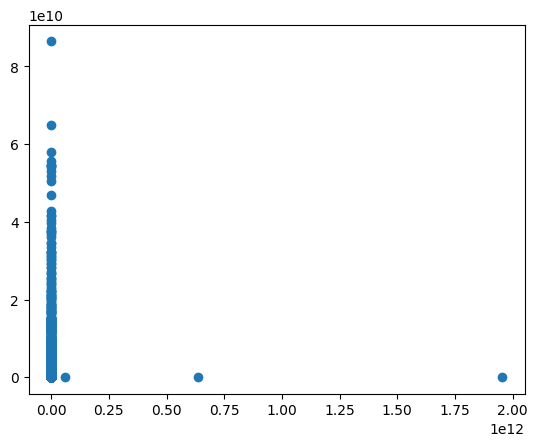

In [24]:
random_indices = n_random_row_incides(x_train_so4, n = 5000)

import matplotlib.pyplot as plt
plt.scatter(ratio_train_so4[random_indices], y_train_so4[random_indices])

# Preprocessing

In [5]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import r2_score as r2

### GPU ###
# I have majority access to GPU on afternoons on even days, and mornings on odd days

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### DATA ###
# define full path 
path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"

# Load and make torch tensors
# Select the correct 24 columns
x_train = torch.tensor(np.load(path_to_data + 'X_train.npy'))[:, 8:]
y_train = torch.tensor(np.load(path_to_data + 'y_train.npy'))[:, :24]

x_test = torch.tensor(np.load(path_to_data + 'X_test.npy'))[:, 8:]
y_test = torch.tensor(np.load(path_to_data + 'y_test.npy'))[:, :24]

x_val = torch.tensor(np.load(path_to_data + 'X_val.npy'))[:, 8:]
y_val = torch.tensor(np.load(path_to_data + 'y_val.npy'))[:, :24]

### SPECIES ###
# Define column indices for each of the components (24 column version)
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16]

# Define aerosol species and their corresponding indices
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

### SPLIT ###
data_split = ['train', 'val', 'test']

# What are these indices?!
extra_indices = [17, 18, 19, 20, 21, 22, 23] 

Using device: cuda:0


In [6]:
def preprocess_x(eps = 1e-5):
    # STEP 1:
    # Define global normalising constant taken from TRAIN (largest dataset)
    for species, indices in species_indices.items():
            x_train_species_arcsinh_std = torch.arcsinh(x_train[:, indices]).std()
            globals()[f"arcsinh_std_x_{species}"] = x_train_species_arcsinh_std

    for split in data_split:

        # Fetch the data
        x_split = globals()[f'x_{split}']

        # STEP 2: Arcsinh
        x_split_arcsinh = torch.arcsinh(x_split)

        # Copy for norm
        x_split_arcsinh_norm = x_split_arcsinh.clone()

        # STEP 3: normalise by species variance
        for species, indices in species_indices.items():
            # Overwrite: normalise by sepcies variance
            x_split_arcsinh_norm[:, indices] = x_split_arcsinh_norm[:, indices] / globals()[f"arcsinh_std_x_{species}"]

        # SAVE
        globals()[f'x_{split}_arcsinh_norm'] = x_split_arcsinh_norm

    ### COMBINE WITH SPECIES raw data ###
    for split in data_split:
        for species, indices in species_indices.items():
            # Fetch og x
            x_split_species = globals()[f'x_{split}'][:, indices]

            # Fetch arcsinh
            x_split_arcsinh_norm = globals()[f'x_{split}_arcsinh_norm']

            # Add relative rows - NOR for now
            # x_split_species_relative = x_split_species.sum(dim = -1)

            # Get indices of rows where the (OG) sum is zero or lower
            # Remove from x and y 
            # zero_sum_indices = (x_split_species.sum(dim = -1) <= 0).nonzero(as_tuple = True)[0]
            # print(split, species, zero_sum_indices.shape[0])
            # any_under_zero_indices = (x_split_species < 0).any(dim = - 1).nonzero(as_tuple = True)[0]
            # print(split, species, any_under_zero_indices.shape[0])

            # Combine data
            x_split_species_combined_data = torch.concat((x_split_arcsinh_norm, x_split_species), dim = -1)
            print(x_split_species_combined_data.shape)

            # Write
            globals()[f'x_{split}_{species}_combi'] = x_split_species_combined_data

# Preprocesses x_train, x_val, x_test to output
# x_train_arcsinh_norm, x_val_arcsinh_norm, x_test_arcsinh_norm
preprocess_x()

torch.Size([5713910, 29])
torch.Size([5713910, 28])
torch.Size([5713910, 28])
torch.Size([5713910, 28])
torch.Size([2856955, 29])
torch.Size([2856955, 28])
torch.Size([2856955, 28])
torch.Size([2856955, 28])
torch.Size([2856955, 29])
torch.Size([2856955, 28])
torch.Size([2856955, 28])
torch.Size([2856955, 28])


In [7]:
def preprocess_y():
    for split in data_split:

        # Fetch the data
        x_split = globals()[f'x_{split}']
        y_split = globals()[f'y_{split}']

        # STEP 1: DELTA
        y_delta_split = y_split - x_split

        # STEP 2: Split into species
        for species, indices in species_indices.items():

            # Fetch y delta
            y_delta_split_species = y_delta_split[:, indices]

            # SAVE 
            globals()[f'y_delta_{split}_{species}'] = y_delta_split_species

preprocess_y()

In [8]:
#############
### MODEL ###
#############

class Transition_model_species_full_input(nn.Module):
    def __init__(self, out_features, width, depth = 2, bias = 13.0):
        super(Transition_model_species_full_input, self).__init__()
        # this is the self transition bias, added to the logits (prior knowledge), high val
        self.bias = bias
        # define to reshape Transition matrix
        self.out_features = out_features
        # define this once and reuse
        self.transition_identity = torch.eye(out_features).unsqueeze(0)
        self.eps = 1e-8

        # This model always takes 24 inputs 
        self.fc_in = nn.Linear(in_features = 24, out_features = width)

        self.hidden_layers = nn.ModuleList()
        for _ in range(depth -1):
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Linear(in_features = width, out_features = width))
            self.hidden_layers.append(nn.ReLU())

        # for the transition matrix, we want to have a square matrix, 1 for scale factor
        self.fc_out = nn.Linear(in_features = width, out_features = (out_features * out_features))

        # Set all model parameters to double precision
        self.to(torch.float64)

    def forward(self, x):
        # x is shape(batch_size, 24 + species_features)
        # ensure double
        x = x.to(torch.float64)

        # Split the input into two parts
        x_for_network = x[:, :24]
        x_for_transition = x[:, 24:] # may be 4 or 5

        # Pass input into first layer shape(batch_size, 24)
        state = self.fc_in(x_for_network)

        for layer in self.hidden_layers:
            state = layer(state)

        logits = self.fc_out(state)

        # Reshape to get (batch_size, out_features, out_features)
        logits = logits.view(-1, self.out_features, self.out_features)
        # print(logits[0])

        if torch.isnan(logits).any():
            print("NaN detected at logits!")
        if torch.isinf(logits).any():
            print("Inf detected at logits!")

        # Add the bias to the diagonal (self transitions) with in-place operation
        logits.diagonal(dim1 = -2, dim2 = -1).add_(self.bias)
        # print(logits[0])

        # Apply softmax across each row so that column values of that row (last dim) add to 1
        # rows add to 1 (From : To): 100% of the source are redistributed
        # PREVIOUSLY ISSUE (had dim = -1 before which was wrong)
        transition_matrix = F.softmax(logits, dim = -2)

        # Transition matrix without self-transitions
        # Repeat for batch_size
        transition_matrix_no_diag = transition_matrix - self.transition_identity.repeat(transition_matrix.shape[0], 1, 1).to(device)

        # Multiply the input by the transition matrix without diagonal: bmm or matmul work
        deltas = torch.matmul(transition_matrix_no_diag, x_for_transition.unsqueeze(-1)).squeeze(-1)

        # return (batch_size, out_features)
        return deltas

In [9]:
model = Transition_model_species_full_input(out_features = 5, width = 64, depth = 2).to(device)
out = model(x_train_so4_combi[0:3].to(device))

In [ ]:
model = Transition_model_species_full_input(out_features = 5, width = 64, depth = 2).to(device)

# Define loss and optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = torch.nn.MSELoss()

# Make sure its training data
x_train = x_train_so4_combi.double().to(device)
y_train = y_delta_train_so4.double().to(device)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)

# Training loop
epochs = 1

### Validation data ###

# Helper
def n_random_row_incides(x, n = 5000):
    """Returns n random rows from x"""
    # Default is 5000
    indices = np.random.choice(x.shape[0], n, replace = False)
    return indices

# Fix indices for some validation
val_row_indices = n_random_row_incides(x_val, n = 30000)

x_val = x_val_so4_combi.double().to(device)
y_val = y_delta_val_so4.double().to(device)

x_val_subset = x_val[val_row_indices]
# y only ever needed on cpu
y_val_subset = y_val[val_row_indices].cpu()

for epoch in range(epochs):
    model.train()
    
    # Iterate over batches
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        deltas = model(x_batch)
        
        # Calculate loss
        loss = torch.sqrt(criterion(deltas, y_batch))
        
        # Backward pass
        loss.backward()
        optimizer.step()
        # print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

        if batch_idx % 1000 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Training RMSE Loss (og units): {loss.item():.4f}')

        if batch_idx % 5000 == 0:
            model.eval()

            PRED_y_delta_val = model(x_val_subset.to(device)).detach().cpu()

            print("Validation R2 Score on delta sample (og units):")
            print(f"{r2(PRED_y_delta_val, y_val_subset).item():.4f}")

            print("Validation RMSE on delta sample (og units):")
            print(f"{torch.sqrt(criterion(PRED_y_delta_val, y_val_subset)).item():.4f}")

            model.train()
        
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, RMSE Loss: {loss.item():.4f}')

    # overwrite after each epoch
    # torch.save(model.state_dict(), os.path.join("models", "arcsinh_unitvar_transition_bc_10epochs.pth"))

In [ ]:
epochs = 1

model = Transition_model_species_full_input(out_features = 5, width = 64, depth = 2).to(device)

# Define loss and optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = torch.nn.MSELoss()

# Make sure its training data
x_train = x_train_so4_combi.double().to(device)
y_train = y_delta_train_so4.double().to(device)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)

### Validation data ###

x_val = x_val_so4_combi.double().to(device)
y_val = y_delta_val_so4.double().to(device)

val_dataset = TensorDataset(x_val, y_val)
# no shuffle needed
val_loader = DataLoader(val_dataset, batch_size = 256, shuffle = False)

# Initialise lists to track convergence 
loss_per_epoch = []
r2_per_epoch = []
r2_sk_per_epoch = []

val_loss_per_epoch = []
val_r2_per_epoch = []
val_r2_sk_per_epoch = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} commenced ({(epoch)/epochs*100:.2f}% completed)")
    model.train()

    # Initlaise lists within this epoch
    loss_per_batch = []
    r2_per_batch = []
    r2_sk_per_batch = []
    
    # Iterate over batches
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        deltas_batch = model(x_batch)
        
        # Calculate loss for one batch
        loss_batch = torch.sqrt(criterion(deltas_batch, y_batch))

        # https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.r2_score.html
        # code: https://pytorch.org/torcheval/main/_modules/torcheval/metrics/functional/regression/r2_score.html
        # https://discuss.pytorch.org/t/r2-score-return-inf/181348/2
        # order is different: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html 

        with torch.no_grad():
            r2_batch = r2(deltas_batch, y_batch) # torch: pred, truth
            r2_sk_batch = sklearn.metrics.r2_score(y_batch.cpu(), deltas_batch.cpu()) # sklearn: truth, pred
        
        # Backward pass
        loss_batch.backward()
        optimizer.step()

        loss_per_batch.append(loss_batch.item())
        r2_per_batch.append(r2_batch.item())
        r2_sk_per_batch.append(r2_sk_batch)
    
    loss_per_epoch.append(np.mean(loss_per_batch))
    r2_per_epoch.append(np.mean(r2_per_batch))
    r2_sk_per_epoch.append(np.mean(r2_sk_per_batch))
    
    # after each epoch
    model.eval()
    with torch.no_grad():

        # Initlaise lists within this epoch
        val_loss_per_batch = []
        val_r2_per_batch = []
        val_r2_sk_per_batch = []
        
        # Iterate over batches
        for batch_idx, (val_x_batch, val_y_batch) in enumerate(val_loader):
            
            # Forward pass
            val_deltas_batch = model(val_x_batch)
            
            # Calculate loss
            val_loss_batch = torch.sqrt(criterion(val_deltas_batch, val_y_batch))
            val_r2_batch = r2(val_deltas_batch, val_y_batch)
            val_r2_sk_batch = sklearn.metrics.r2_score(val_y_batch.cpu(), val_deltas_batch.cpu())

            val_loss_per_batch.append(val_loss_batch.item())
            val_r2_per_batch.append(val_r2_batch.item())
            val_r2_sk_per_batch.append(val_r2_sk_batch)

        val_loss_per_epoch.append(np.mean(val_loss_per_batch))
        val_r2_per_epoch.append(np.mean(val_r2_per_batch))
        val_r2_sk_per_epoch.append(np.mean(val_r2_sk_per_batch))

        # Back to training
    model.train()

Epoch 1/1 commenced (0.00% completed)


In [ ]:
# nominator has zero var
y_true = np.full((100,), fill_value = 1.)
y_pred = np.random.randn(100)

# sklearn order is truth pred: inf -> 0
print(sklearn.metrics.r2_score(y_true, y_pred))
# 0.0

print(sklearn.metrics.r2_score(y_true, y_pred, force_finite = False))
# -inf

# swap: nominator now has zero var
y_true = np.random.randn(100)
y_pred = np.full((100,), fill_value = 1.) # constant prediction

print(sklearn.metrics.r2_score(y_true, y_pred))
# 0.0

print(sklearn.metrics.r2_score(y_true, y_pred, force_finite = False))
# -inf

0.0
-inf
-0.9971232645368815


/home/kim/anaconda3/envs/aero/lib/python3.10/site-packages/sklearn/metrics/_regression.py:930: RuntimeWarning: divide by zero encountered in divide
  output_scores = 1 - (numerator / denominator)


In [ ]:
np.mean(loss_per_batch)

print(val_r2_per_epoch)
print(val_r2_sk_per_epoch)
print(r2_per_epoch)

[-8591448242.16085]
[-8591448242.160776]
[0.16124264001264285]


: 

In [105]:
val_r2_sk_per_batch

[-12402.343079553524,
 -979.7851831959051,
 -330.62210283100313,
 -239.16007511027024,
 -190.13046509928057,
 -208.49904914766915,
 -215.99040973155306,
 -135.46098184666948,
 -150.9365601862619,
 -113.74633284246056,
 -136.89235969094938,
 -341.8866414527608,
 -587.5110357730935,
 -1211.4174874729165,
 -1624.3690802078136,
 -1453.4613763419268,
 -888.7108147711381,
 -1006.3405409171377,
 -1042.0245894519458,
 -683.3621926628118,
 -361.24026781688184,
 -191.107635984423,
 -183.4189858883984,
 -218.49928445139957,
 -202.58827949955938,
 -166.31770769766632,
 -228.7571434762694,
 -154.86823583327492,
 -130.11970363374772,
 -141.51343864368124,
 -186.1927286831611,
 -415.5382838900863,
 -457.1504370308132,
 -203.78597062191284,
 -97.6195946245003,
 -103.40973261032691,
 -132.4745123533225,
 -201.0353907457187,
 -351.84886555909475,
 -211.73398401185676,
 -155.87129571843383,
 -194.71379727006257,
 -299.6539399500774,
 -307.9164946477896,
 -334.05081727161274,
 -626.9507312500416,
 -847.45

In [ ]:
from sklearn.metrics import r2_score

In [60]:
mean_squared_error(val_deltas_batch.cpu(), val_y_batch.cpu())

2783.3613309665216

In [49]:
val_r2_batch = r2(val_deltas_batch, val_y_batch)
val_r2_batch

tensor(-1.3046e+12, device='cuda:0', dtype=torch.float64)

In [65]:
torch.set_printoptions(precision=10, sci_mode=False)
print(r2(val_deltas_batch, val_y_batch))
print(r2_score(val_deltas_batch.cpu(), val_y_batch.cpu()))

tensor(-1304649879639.6735839844, device='cuda:0', dtype=torch.float64)
-17.39352084075829


In [81]:
import statistics

In [73]:
r2_score_torch(val_deltas_batch, val_y_batch)

tensor(39.2647856420, device='cuda:0', dtype=torch.float64)

In [ ]:
import torch

def r2_score_torch(pred, true, force_finite = True):
    # Flatten tensors
    pred = pred.flatten()
    true = true.flatten()
    
    # Calculate the total sum of squares (ss_total)
    ss_total = torch.sum((true - true.mean())**2)
    
    # If ss_total is zero (all true values are identical), return R² = 1 (perfect fit)
    if ss_total == 0:
        return torch.tensor(1.0)
    
    # Calculate the residual sum of squares (ss_residual)
    ss_residual = torch.sum((true - pred)**2)
    
    # Standard formula for R²
    numerator = ss_total - ss_residual
    denominator = ss_total
    
    if force_finite:
        # If the denominator is zero, avoid division by zero and set R² to 0
        if denominator == 0:
            return torch.tensor(0.0)
        
        # If the numerator is zero, it implies perfect predictions, so set R² to 1
        if numerator == 0:
            return torch.tensor(1.0)

        # If neither the numerator nor the denominator is zero, compute R² normally
        output_score = 1 - (numerator / denominator)
        
        # Ensure the output is finite
        if torch.isinf(output_score) or torch.isnan(output_score):
            return torch.tensor(0.0)
        
        return output_score

    else:
        # Standard formula without forcing finite values
        return 1 - (numerator / denominator)
